In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
import matplotlib.patches as mpatches

from torch.autograd import Variable
import torch
import math

import os
import sys
import re
from collections import OrderedDict

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "Sans Serif"
plt.rcParams['font.serif'] = "cm"

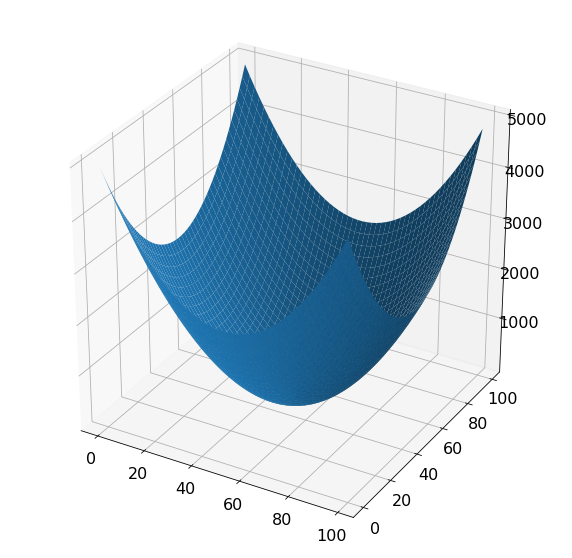

In [5]:
def score_fn(W):
    return (W[0]-50)**2 + (W[1]-50)**2
    #return -(W[0]**2-90**2 + 0.3*(W[1]**2-70**2))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")

xmesh, ymesh = np.mgrid[0:99:50j,0:99:50j]
score_mesh = score_fn(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, score_mesh)

In [12]:
def ngraph_test_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_time = OrderedDict()
    
    with open(fname) as fp:  
        for cnt, line in enumerate(fp):
            print("Line {}: {}".format(cnt, line))
            # batch size: 2
            pattern = re.compile(r"batch size: (\d+)")
            match = pattern.match(line)
            if match:
                bs_str = match.group()
                print(bs_str)
    return dictionary_acc, dictionary_time



In [13]:
dictionary_acc, dictionary_time = ngraph_test_result("ngraph-test-result.log")


Line 0: batch size: 2

batch size: 2
Line 1: test data set: test

Line 2: image size: 1, minus: 1

Line 3: Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.119

Line 4: Accuracy of Bread : 88 %

Line 5: Accuracy of DairyProduct : 81 %

Line 6: Accuracy of Dessert : 97 %

Line 7: Accuracy of   Egg : 88 %

Line 8: Accuracy of Friedfood : 92 %

Line 9: Accuracy of  Meat : 91 %

Line 10: Accuracy of Noodles-Pasta : 92 %

Line 11: Accuracy of  Rice : 98 %

Line 12: Accuracy of Seafood : 98 %

Line 13: Accuracy of  Soup : 91 %

Line 14: Accuracy of Vegetable-Fruit : 97 %

Line 15: 174.36557960510254 seconds

Line 16: batch size: 4

batch size: 4
Line 17: test data set: test

Line 18: image size: 3, minus: 1

Line 19: Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.060

Line 20: Accuracy of Bread : 88 %

Line 21: Accuracy of DairyProduct : 81 %

Line 22: Accuracy of Dessert : 97 %

Line 23: Accuracy of   Egg : 88 %

Line 24: Accuracy of Friedfood

In [24]:
def pretraining_result(fname):

    dictionary_best_top1 = OrderedDict()
    dictionary_top1 = OrderedDict()
    dictionary_loss = OrderedDict()
    
    with open(fname) as fp:  
        for cnt, line in enumerate(fp):
            # print("Line {}: {}".format(cnt, line))
            # 2018-11-08 22:43:24,857 - --- validate (epoch=556)-----------
            pattern = re.compile(r"(\S+) (\S+) - --- validate \(epoch=(\d+)\)-----------")
            match = pattern.match(line)
            if match:
                date_str, time_str, epoch_str = match.groups()

            # 2018-11-08 17:13:20,700 - ==> Top1: 44.620    Top5: 91.650    Loss: 1.529

            pattern = re.compile(r"(\S+) (\S+) - ==> Top1: (\d+.\d+)    Top5: (\d+.\d+)    Loss: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                date_str, time_str, top1_str, top5_str, loss_str = match.groups()

            # 2018-11-08 17:13:20,701 - ==> Best Top1: 44.620   On Epoch: 0
            pattern = re.compile(r"(\S+) (\S+) - ==> Best Top1: (\d+.\d+)   On Epoch: (\d+)")
            match = pattern.match(line)
            if match:
                date_str, time_str, best_top1_str, best_epoch_str = match.groups()
                print('Epoch: {:s}, best top1: {:s}, top1: {:s}, loss: {:s}'.
                      format(epoch_str, best_top1_str, top1_str, loss_str))

                Epoch = int(epoch_str)
                best_top1 = float("{:.1f}".format(float(best_top1_str)))
                top1 = float("{:.1f}".format(float(top1_str)))
                loss = float("{0:.2f}".format(float(loss_str)))
                
                dictionary_best_top1[Epoch] = best_top1
                dictionary_top1[Epoch] = top1
                dictionary_loss[Epoch] = loss
                    
    #print(dictionary_top1)
    return dictionary_best_top1, dictionary_top1, dictionary_loss

In [25]:
import matplotlib.pyplot as plt
import itertools

def show_pretraining_result(dictionary_best_top1, dictionary_top1, dictionary_loss):
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('Pretraining Resnet56 Baseline', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    itertools.islice(dictionary_top1.keys(), 0, None, 10)
    
    l1, = ax1.plot(list(dictionary_best_top1.keys()), list(dictionary_best_top1.values()), 'b-')
    for i, j in zip(list(itertools.islice(dictionary_best_top1.keys(), 0, None, 50)),
                    list(itertools.islice(dictionary_best_top1.values(), 0, None, 50))):
        ax1.annotate('%s' %j, xy=(i, j), xytext=(-10, 20), textcoords='offset points', color='b')
    
    l2, = ax1.plot(list(dictionary_top1.keys()), list(dictionary_top1.values()), 'g-')
    for i, j in zip(list(itertools.islice(dictionary_top1.keys(), 0, None, 50)),
                    list(itertools.islice(dictionary_top1.values(), 0, None, 50))):
        ax1.annotate('%s' %j, xy=(i, j), xytext=(-10, -20), textcoords='offset points', color='g')
    
    l3, = ax2.plot(list(dictionary_loss.keys()), list(dictionary_loss.values()), 'r--')
    for i, j in zip(list(itertools.islice(dictionary_loss.keys(), 0, None, 50)),
                    list(itertools.islice(dictionary_loss.values(), 0, None, 50))):
        ax1.annotate('%s' %j, xy=(i, j), xytext=(-10, 50), textcoords='offset points', color='r')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Epoch', fontsize=20)
    ax1.set_ylabel('Accuracy', fontsize=20, color='#008888')
    ax2.set_ylabel('Loss', fontsize=20, color='r')

    ax1.set(ylim=[0, 100])
    #ax2.set(ylim=[0.1, 0.2])

    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3],
               labels=['Best Accuracy', 'Validation Accuracy', 'Loss'], fontsize=20, loc='right')

    plt.show()

In [26]:
# fname = './pertrain base line/resnet56_cifar_baseline v1.log'
fname = './pertrain base line/2018.11.12-210049/2018.11.12-210049.log'
dictionary_best_top1, dictionary_top1, dictionary_loss = pretraining_result(fname)

Epoch: 0, best top1: 10.300, top1: 10.300, loss: 2.304
Epoch: 1, best top1: 11.470, top1: 11.470, loss: 2.290
Epoch: 2, best top1: 21.130, top1: 21.130, loss: 2.226
Epoch: 3, best top1: 38.060, top1: 38.060, loss: 1.679
Epoch: 4, best top1: 47.000, top1: 47.000, loss: 1.444
Epoch: 5, best top1: 53.470, top1: 53.470, loss: 1.298
Epoch: 6, best top1: 53.470, top1: 52.960, loss: 1.416
Epoch: 7, best top1: 62.850, top1: 62.850, loss: 1.128
Epoch: 8, best top1: 68.310, top1: 68.310, loss: 0.926
Epoch: 9, best top1: 68.310, top1: 67.140, loss: 0.963
Epoch: 10, best top1: 75.000, top1: 75.000, loss: 0.750
Epoch: 11, best top1: 75.000, top1: 74.110, loss: 0.784
Epoch: 12, best top1: 76.870, top1: 76.870, loss: 0.681
Epoch: 13, best top1: 76.870, top1: 73.350, loss: 0.807
Epoch: 14, best top1: 76.870, top1: 75.720, loss: 0.739
Epoch: 15, best top1: 79.060, top1: 79.060, loss: 0.602
Epoch: 16, best top1: 79.060, top1: 77.110, loss: 0.667
Epoch: 17, best top1: 79.060, top1: 76.300, loss: 0.713
Ep

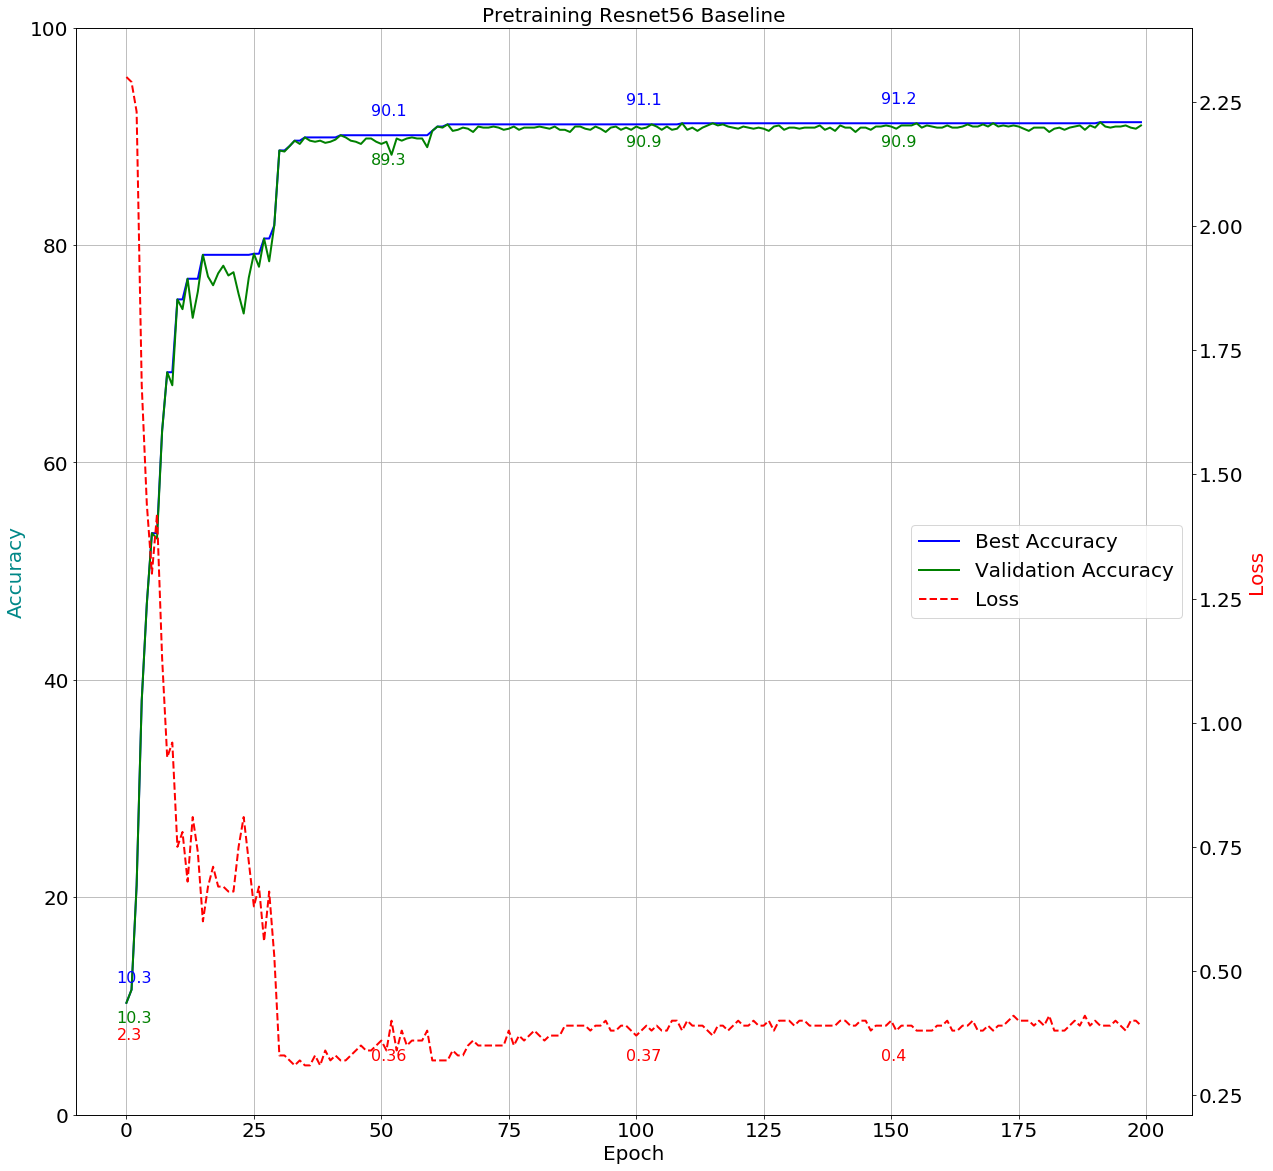

In [27]:
show_pretraining_result(dictionary_best_top1, dictionary_top1, dictionary_loss)

In [28]:
def pruning_result(fname):

    dictionary_score = OrderedDict()
    dictionary_train_acc = OrderedDict()
    dictionary_val_acc = OrderedDict()
    dictionary_test_acc = OrderedDict()
    dictionary_sparsity = OrderedDict()
    
    with open(fname) as fp:  
        for cnt, line in enumerate(fp):
            #print("Line {}: {}".format(cnt, line))
            # 1 trials: score: 0.1329, train_acc:99.2178, val_acc:97.5400, test_acc:90.3700, sparsity:63.4339
            pattern1 = re.compile(r"(\d+) trials: score: (-?\d+.\d+), train_acc:(\d+.\d+), val_acc:(\d+.\d+), test_acc:(\d+.\d+), sparsity:(\d+.\d+)")
            match1 = pattern1.match(line)
            if match1:
                round_str, score_str, train_acc_str, val_acc_str, test_acc_str, sparsity_str = match1.groups()
                print('round:{:s}, score:{:s}, train_acc:{:s}, val_acc:{:s}, test_acc:{:s}, sparsity:{:s}'.
                      format(round_str, score_str, train_acc_str, val_acc_str, test_acc_str, sparsity_str))

                round_str, score_str, train_acc_str, val_acc_str, test_acc_str, sparsity_str
                round = int(round_str)
                score = float("{:.3f}".format(float(score_str)))
                train_acc = float("{0:.1f}".format(float(train_acc_str)))
                val_acc = float("{0:.1f}".format(float(val_acc_str)))
                test_acc = float("{0:.1f}".format(float(test_acc_str)))
                sparsity = float("{0:.1f}".format(float(sparsity_str)))
                
                dictionary_score[round] = score
                dictionary_train_acc[round] = train_acc
                dictionary_val_acc[round] = val_acc
                dictionary_test_acc[round] = test_acc
                dictionary_sparsity[round] = sparsity
    
    #print(dictionary_top1)
    return dictionary_score, dictionary_train_acc, dictionary_val_acc, dictionary_test_acc, dictionary_sparsity

In [29]:
import matplotlib.pyplot as plt

def show_pruning_result(dictionary_score, dictionary_train_acc, dictionary_val_acc,
                     dictionary_test_acc, dictionary_sparsity, hyperparameter_method, constraint):
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title(hyperparameter_method, fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    #plt.plot(list(dictionary_train_acc.keys()), list(dictionary_train_acc.values()))
    #plt.plot(list(dictionary_val_acc.keys()), list(dictionary_val_acc.values()))
    l1, = ax1.plot(list(dictionary_test_acc.keys()), list(dictionary_test_acc.values()), 'bo-')
    for i,j in zip(list(dictionary_test_acc.keys()), list(dictionary_test_acc.values())):
        ax1.annotate('%s' %j, xy=(i, j), xytext=(-10, 20), textcoords='offset points')
        #ax1.annotate('(%s,' %i, xy=(i,j))

    l2, = ax1.plot(list(dictionary_sparsity.keys()), list(dictionary_sparsity.values()), 'g-')
    for i,j in zip(list(dictionary_sparsity.keys()), list(dictionary_sparsity.values())):
        ax1.annotate('%s' %j, xy=(i, j), xytext=(-10, 20), textcoords='offset points')
        #ax1.annotate('(%s,' %i, xy=(i,j))
    if(constraint == True):
        ax1.fill_between([0, 20], [67.5, 67.5], [72.5, 72.5], color= '#00FF00', alpha=.02, linewidth=0)
        x = np.linspace(0, 20, 100)
        y1, y2, y3 = np.linspace(70, 70, 100), np.linspace(67.5, 67.5, 100), np.linspace(72.5, 72.5, 100)
        ax1.plot(x, y1, 'g-', x, y2, 'g--', x, y3, 'g--')
            
    l3, = ax2.plot(list(dictionary_score.keys()), list(dictionary_score.values()), 'r--')
    for i,j in zip(list(dictionary_score.keys()), list(dictionary_score.values())):
        ax2.annotate('%s' %j, xy=(i, j), xytext=(-10, 20), textcoords='offset points')
        #ax2.annotate('(%s,' %i, xy=(i,j))
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('round', fontsize=20)
    ax1.set_ylabel('Accuracy / Sparsity', fontsize=20, color='#008888')
    ax2.set_ylabel('Score', fontsize=20, color='r')

    ax1.set(ylim=[0, 100])
    #ax2.set(ylim=[0.1, 0.2])

    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3],
               labels=['test_acc', 'sparsity', 'score'],  loc='best')

    plt.show()

round:1, score:0.1329, train_acc:99.2178, val_acc:97.5400, test_acc:90.3700, sparsity:63.4339
round:2, score:0.1397, train_acc:99.2000, val_acc:96.9200, test_acc:90.0700, sparsity:63.6942
round:3, score:0.1390, train_acc:99.2111, val_acc:97.5600, test_acc:90.0100, sparsity:61.5247
round:4, score:0.1428, train_acc:98.5911, val_acc:95.2600, test_acc:90.0000, sparsity:65.9488
round:5, score:0.1333, train_acc:98.7778, val_acc:96.1600, test_acc:90.1200, sparsity:67.9112
round:6, score:0.1291, train_acc:99.5467, val_acc:97.8800, test_acc:90.7800, sparsity:63.3144
round:7, score:0.1315, train_acc:99.5200, val_acc:97.8000, test_acc:90.5300, sparsity:62.8851
round:8, score:0.1456, train_acc:99.5111, val_acc:98.2200, test_acc:89.8900, sparsity:57.4099
round:9, score:0.1288, train_acc:99.0044, val_acc:96.9600, test_acc:89.9700, sparsity:67.1856
round:10, score:0.1292, train_acc:99.6444, val_acc:98.2200, test_acc:90.6200, sparsity:62.0543
round:11, score:0.1221, train_acc:99.2667, val_acc:97.1200,

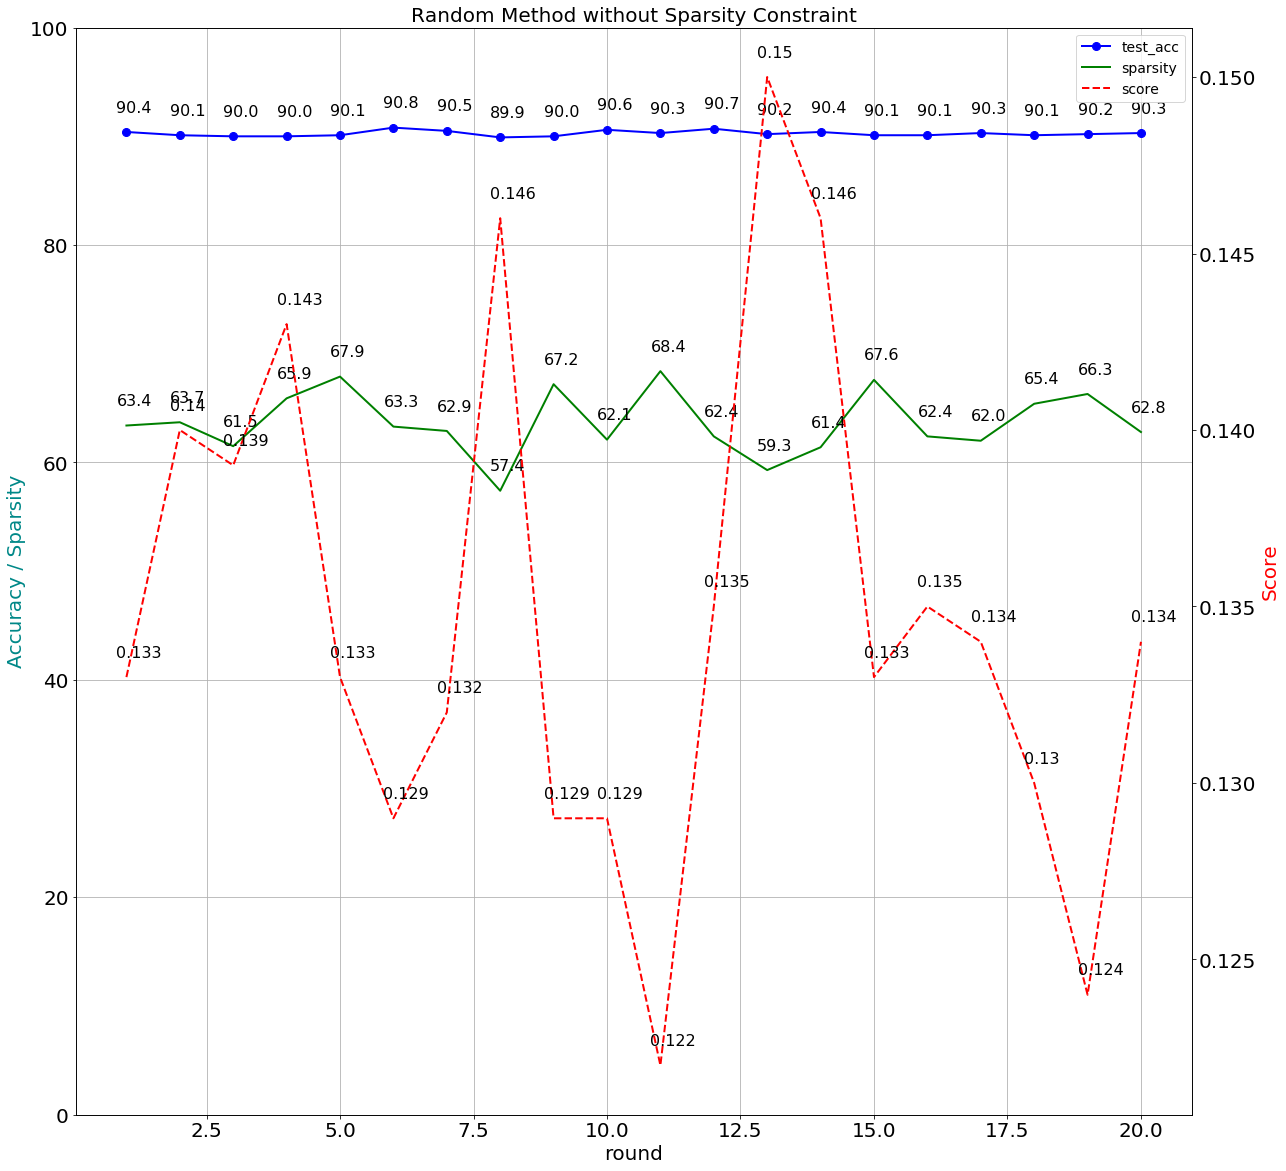

In [30]:
fname = './rnd_no_constraint.log'
dictionary_score_rnd, dictionary_train_acc_rnd, dictionary_val_acc_rnd, dictionary_test_acc_rnd, dictionary_sparsity_rnd = pruning_result(fname)
show_pruning_result(dictionary_score_rnd, dictionary_train_acc_rnd, dictionary_val_acc_rnd,
                dictionary_test_acc_rnd, dictionary_sparsity_rnd, "Random Method without Sparsity Constraint",
                constraint=False)

round:1, score:0.1645, train_acc:91.4511, val_acc:93.5800, test_acc:88.2200, sparsity:66.5504
round:2, score:0.2011, train_acc:89.0778, val_acc:92.6400, test_acc:86.9400, sparsity:57.5066
round:3, score:0.1676, train_acc:92.9022, val_acc:95.2800, test_acc:88.7800, sparsity:59.8809
round:4, score:0.1566, train_acc:94.2422, val_acc:95.9200, test_acc:88.5700, sparsity:61.4135
round:5, score:0.1747, train_acc:92.0444, val_acc:94.1800, test_acc:88.4200, sparsity:61.1647
round:6, score:0.1752, train_acc:88.4511, val_acc:92.3200, test_acc:87.2300, sparsity:67.2153
round:7, score:0.1759, train_acc:92.1822, val_acc:94.6600, test_acc:88.4100, sparsity:59.1565
round:8, score:0.1444, train_acc:95.2178, val_acc:96.6200, test_acc:89.2400, sparsity:63.1227
round:9, score:0.2006, train_acc:88.6067, val_acc:91.5600, test_acc:86.8200, sparsity:61.2630
round:10, score:0.1539, train_acc:92.2044, val_acc:94.5600, test_acc:88.3500, sparsity:66.8386
round:11, score:0.1585, train_acc:91.5978, val_acc:94.3400,

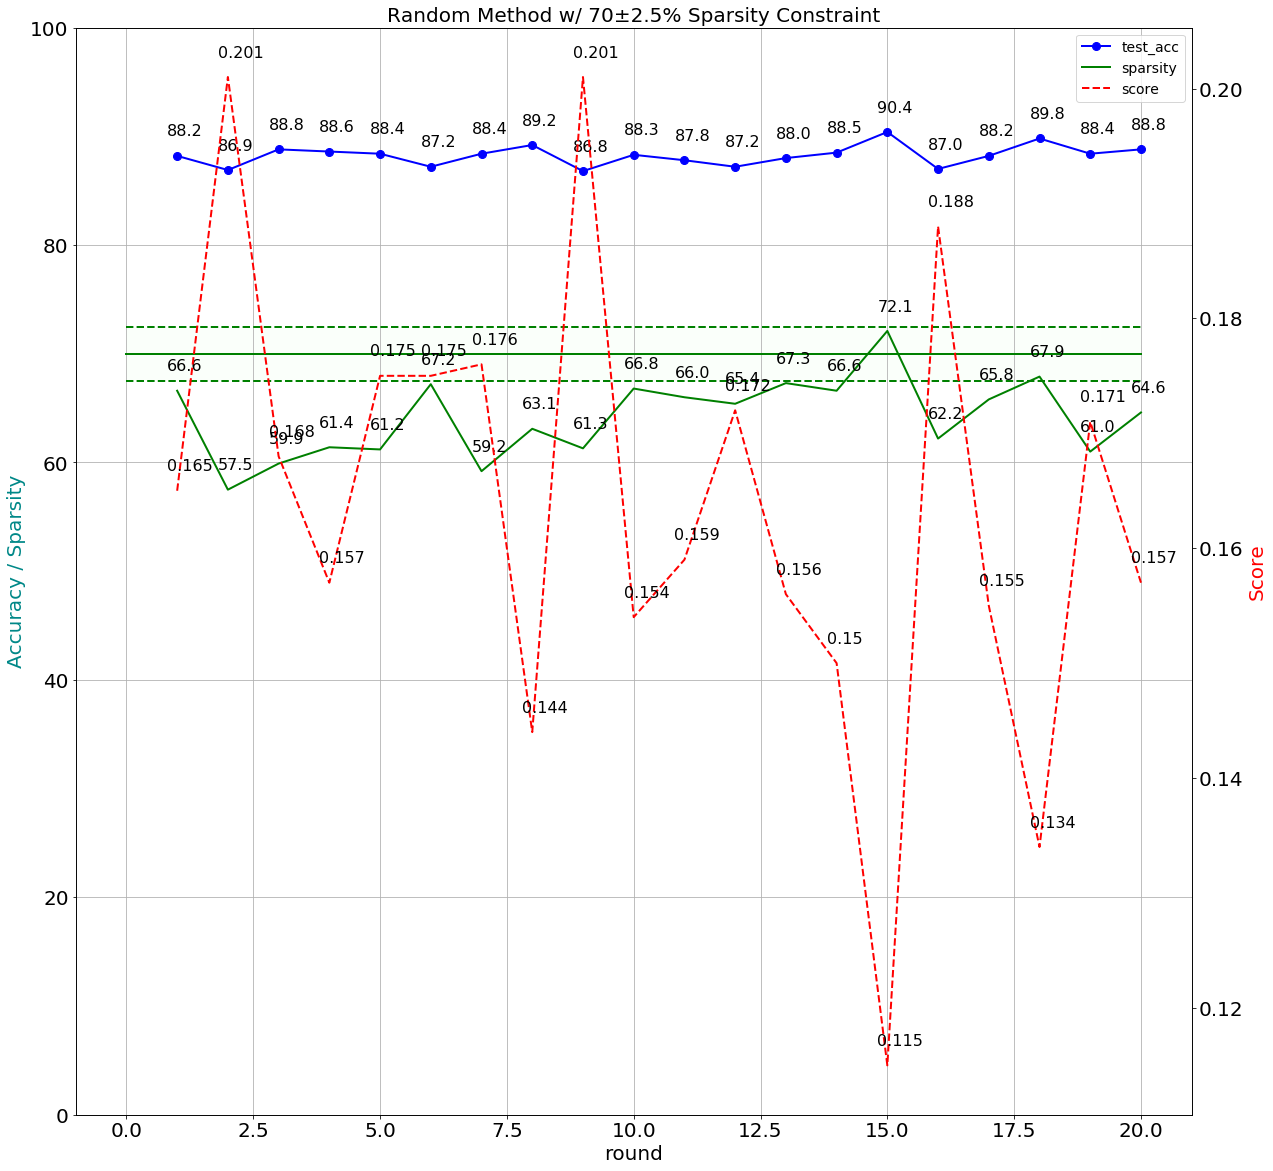

In [31]:
fname = './rnd_constraint.log'
dictionary_score_rnd_con, dictionary_train_acc_rnd_con, dictionary_val_acc_rnd_con, dictionary_test_acc_rnd_con, dictionary_sparsity_rnd_con = pruning_result(fname)
show_pruning_result(dictionary_score_rnd_con, dictionary_train_acc_rnd_con, dictionary_val_acc_rnd_con,
                dictionary_test_acc_rnd_con, dictionary_sparsity_rnd_con, "Random Method w/ 70\xb12.5% Sparsity Constraint",
                constraint=True)

round:1, score:0.1250, train_acc:99.6578, val_acc:97.9800, test_acc:90.5200, sparsity:63.3868
round:2, score:0.1214, train_acc:99.2489, val_acc:97.1000, test_acc:90.4100, sparsity:68.9222
round:3, score:0.1284, train_acc:99.3200, val_acc:97.5600, test_acc:90.0800, sparsity:65.3271
round:4, score:0.1541, train_acc:98.7867, val_acc:96.4400, test_acc:90.1400, sparsity:59.4185
round:5, score:0.1394, train_acc:99.6600, val_acc:98.5200, test_acc:90.5300, sparsity:58.4627
round:6, score:0.1358, train_acc:99.4089, val_acc:97.2000, test_acc:90.5900, sparsity:62.8610
round:7, score:0.1365, train_acc:99.2667, val_acc:97.2600, test_acc:90.5400, sparsity:63.0949
round:8, score:0.1289, train_acc:99.2022, val_acc:97.2000, test_acc:90.0800, sparsity:66.1005
round:9, score:0.1333, train_acc:98.7867, val_acc:96.6000, test_acc:89.5800, sparsity:66.8992
round:10, score:0.1418, train_acc:99.6622, val_acc:97.9600, test_acc:90.4300, sparsity:57.6561
round:11, score:0.1308, train_acc:99.6756, val_acc:98.3000,

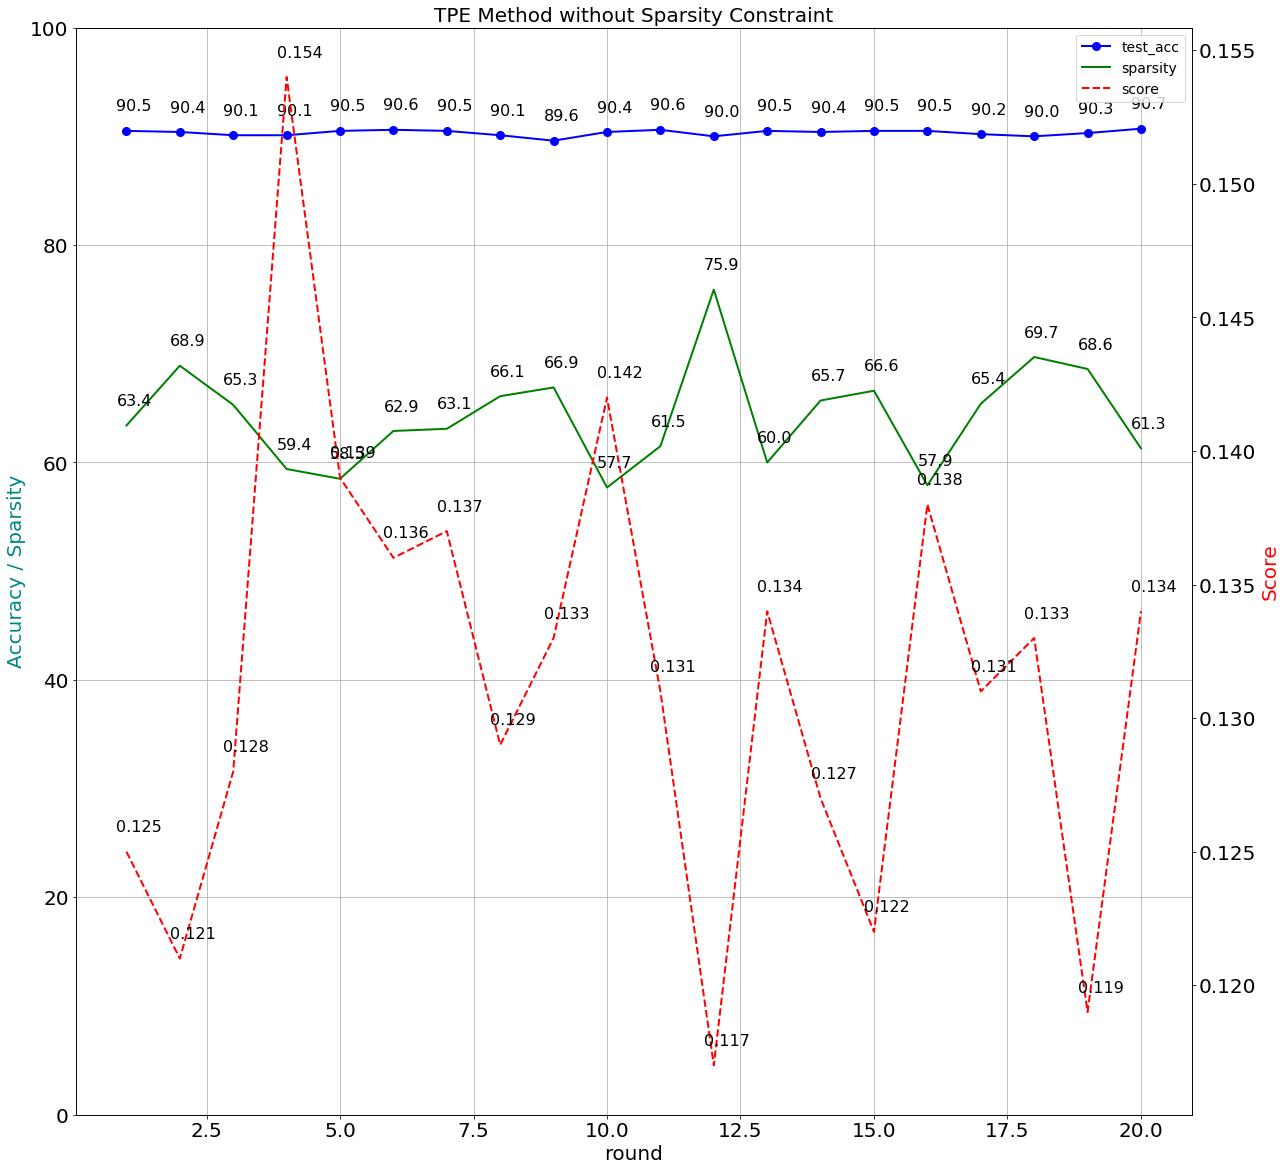

In [32]:
fname = './tpe_no_constraint.log'
dictionary_score_tpe, dictionary_train_acc_tpe, dictionary_val_acc_tpe, dictionary_test_acc_tpe, dictionary_sparsity_tpe = pruning_result(fname)
show_pruning_result(dictionary_score_tpe, dictionary_train_acc_tpe, dictionary_val_acc_tpe,
                dictionary_test_acc_tpe, dictionary_sparsity_tpe, "TPE Method without Sparsity Constraint",
                constraint=False)

round:1, score:0.1535, train_acc:92.5667, val_acc:94.7400, test_acc:88.1000, sparsity:66.3634
round:2, score:0.1888, train_acc:87.6733, val_acc:91.8800, test_acc:86.6000, sparsity:64.1261
round:3, score:0.2123, train_acc:82.1822, val_acc:88.7400, test_acc:84.5100, sparsity:66.7591
round:4, score:0.1523, train_acc:92.8400, val_acc:95.7200, test_acc:88.3900, sparsity:63.4922
round:5, score:0.1908, train_acc:87.8933, val_acc:92.3800, test_acc:87.0800, sparsity:61.7990
round:6, score:0.1702, train_acc:91.5444, val_acc:93.7000, test_acc:87.2700, sparsity:64.2736
round:7, score:0.1793, train_acc:88.6244, val_acc:92.6400, test_acc:87.3000, sparsity:64.7719
round:8, score:0.1388, train_acc:94.4311, val_acc:96.3400, test_acc:88.8200, sparsity:65.9181
round:9, score:0.1591, train_acc:92.4044, val_acc:94.9600, test_acc:88.4700, sparsity:63.7628
round:10, score:0.1657, train_acc:91.4022, val_acc:94.6000, test_acc:88.0300, sparsity:62.7523
round:11, score:0.1156, train_acc:99.6956, val_acc:97.1600,

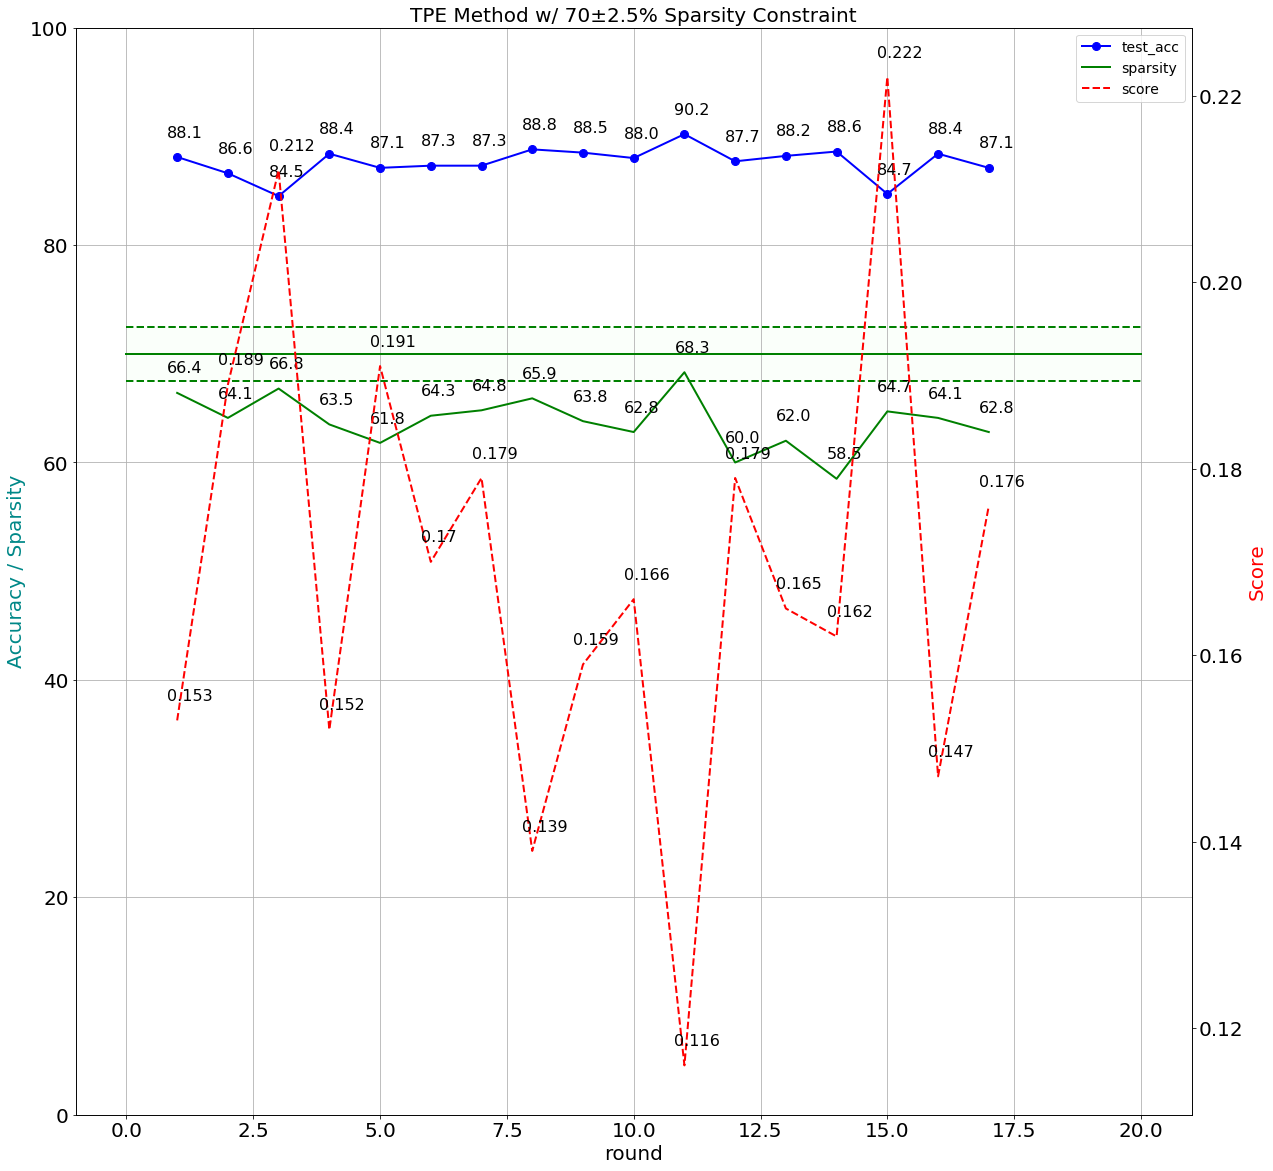

In [33]:
fname = './tpe_constraint.log'
dictionary_score_tpe_con, dictionary_train_acc_tpe_con, dictionary_val_acc_tpe_con, dictionary_test_acc_tpe_con, dictionary_sparsity_tpe_con = pruning_result(fname)
show_pruning_result(dictionary_score_tpe_con, dictionary_train_acc_tpe_con, dictionary_val_acc_tpe_con,
                dictionary_test_acc_tpe_con, dictionary_sparsity_tpe_con, "TPE Method w/ 70\xb12.5% Sparsity Constraint",
                constraint=True)

round:1, score:0.1375, train_acc:97.6578, val_acc:95.0000, test_acc:91.1600, sparsity:68.5825
round:2, score:0.1407, train_acc:97.6556, val_acc:95.0000, test_acc:90.9500, sparsity:67.9800
round:3, score:0.1664, train_acc:93.6911, val_acc:93.4400, test_acc:89.0100, sparsity:66.3998
round:4, score:0.1301, train_acc:97.7444, val_acc:95.2600, test_acc:90.8300, sparsity:71.1025
round:5, score:0.1355, train_acc:97.6422, val_acc:95.6000, test_acc:90.9800, sparsity:69.3519
round:6, score:0.1610, train_acc:93.5622, val_acc:93.7000, test_acc:88.9200, sparsity:67.3438
round:7, score:0.1343, train_acc:97.4778, val_acc:94.8000, test_acc:90.8500, sparsity:70.6276
round:8, score:0.1298, train_acc:97.6578, val_acc:95.5000, test_acc:91.0200, sparsity:70.9180
round:9, score:0.1270, train_acc:97.6822, val_acc:95.2200, test_acc:90.9700, sparsity:71.4041
round:10, score:0.1328, train_acc:97.5867, val_acc:94.9800, test_acc:91.0700, sparsity:69.9838
round:11, score:0.1345, train_acc:97.4867, val_acc:95.1400,

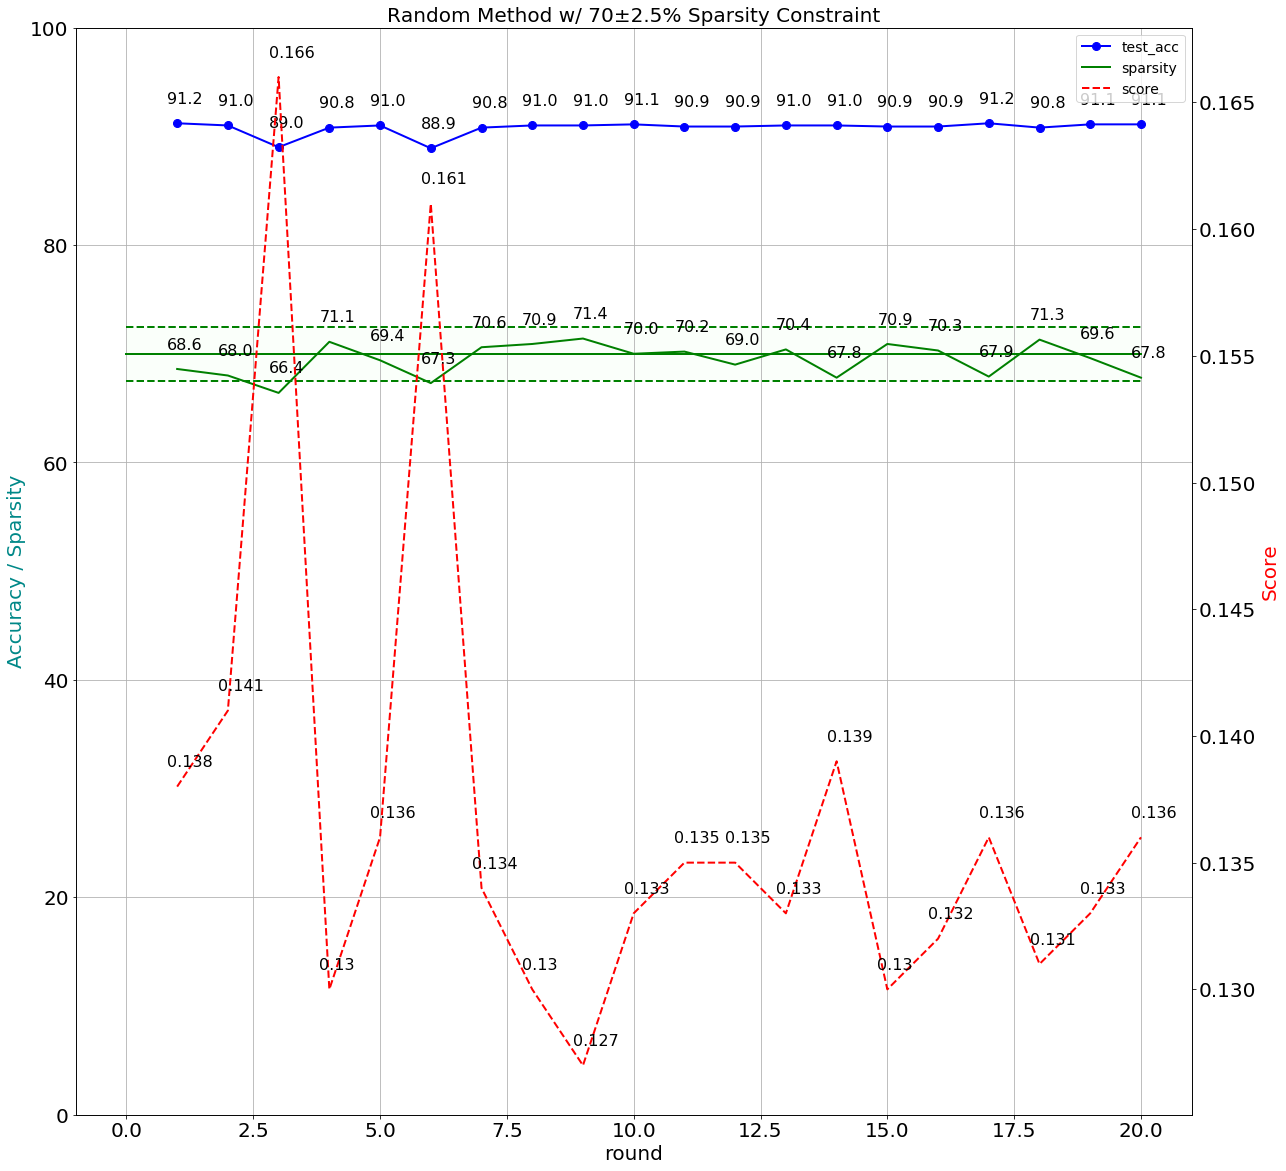

In [39]:
fname = './rnd_constraint_v2.log'
dictionary_score_rnd_con_2, dictionary_train_acc_rnd_con_2, dictionary_val_acc_rnd_con_2, dictionary_test_acc_rnd_con_2, dictionary_sparsity_rnd_con_2 = pruning_result(fname)
show_pruning_result(dictionary_score_rnd_con_2, dictionary_train_acc_rnd_con_2, dictionary_val_acc_rnd_con_2,
                dictionary_test_acc_rnd_con_2, dictionary_sparsity_rnd_con_2, "Random Method w/ 70\xb12.5% Sparsity Constraint",
                constraint=True)

round:1, score:0.1341, train_acc:97.6156, val_acc:95.7600, test_acc:90.7400, sparsity:68.1798
round:2, score:0.1301, train_acc:97.7556, val_acc:95.8200, test_acc:91.1500, sparsity:70.2498
round:3, score:0.1326, train_acc:97.6667, val_acc:95.7400, test_acc:90.7400, sparsity:69.6132
round:4, score:0.1304, train_acc:97.7600, val_acc:95.7000, test_acc:91.2000, sparsity:69.5233
round:5, score:0.1285, train_acc:97.3822, val_acc:95.3200, test_acc:90.7800, sparsity:71.0469
round:6, score:0.1352, train_acc:97.5956, val_acc:95.7200, test_acc:90.6400, sparsity:69.0773
round:7, score:0.1494, train_acc:94.1178, val_acc:95.0000, test_acc:89.0900, sparsity:66.8788
round:8, score:0.1267, train_acc:97.7778, val_acc:95.7000, test_acc:91.0600, sparsity:71.2922
round:9, score:0.1305, train_acc:97.4067, val_acc:95.6400, test_acc:90.9800, sparsity:71.0287
round:10, score:0.1298, train_acc:97.6311, val_acc:95.8000, test_acc:91.0500, sparsity:69.4719
round:11, score:0.1299, train_acc:97.5444, val_acc:96.0600,

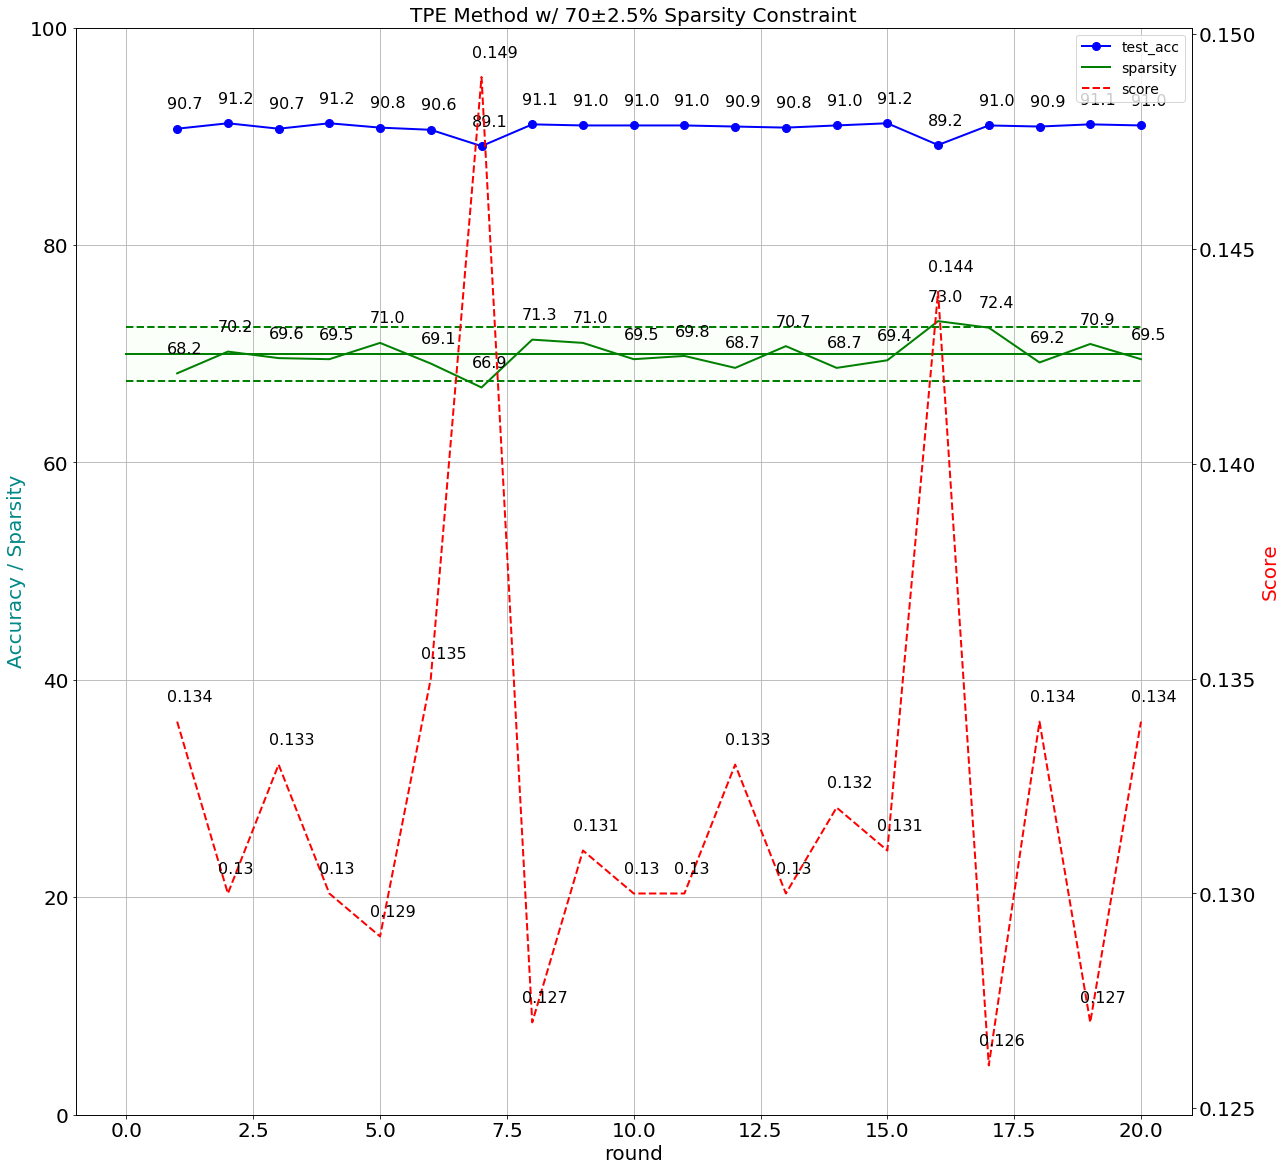

In [41]:
fname = './tpe_constraint_v2.log'
dictionary_score_tpe_con_2, dictionary_train_acc_tpe_con_2, dictionary_val_acc_tpe_con_2, dictionary_test_acc_tpe_con_2, dictionary_sparsity_tpe_con_2 = pruning_result(fname)
show_pruning_result(dictionary_score_tpe_con_2, dictionary_train_acc_tpe_con_2, dictionary_val_acc_tpe_con_2,
                dictionary_test_acc_tpe_con_2, dictionary_sparsity_tpe_con_2, "TPE Method w/ 70\xb12.5% Sparsity Constraint",
                constraint=True)